# 实验 2 初步预测股票收益

## 背景介绍：

量化投资有两大主流门派：主动投资和被动投资。这也代表了不同的学术观点：市场到底是不是有效的？

如果市场是有效的，那我们一定能找到赚钱的办法，只要付诸足够的努力，再加上一点点小小的天赋，我们应该是可以赚钱的，毕竟已经有那么多先贤赚了钱，那我们一定会倾向于选择主动投资。

如果市场是无效的，那我们即使一辈子苦苦追寻，上下求索，也永远不可能超越市场，考虑到手续费等因素，再去除市场因素，那我们处于一个负和博弈中，并且我们相比其他人并不占任何优势，那我们不如选择被动投资。
  
如果我们要选择主动投资的道路，那就意味着我们要求自己的预测能力超过市场中基金经理的平均水平。
这是一条很艰难的道路，我们是在用科学家的手段做艺术家的事，不过，虽然作品缺点灵魂，但总归也还能看。

本章的重点就是，如何获得一个对股票收益的预测？

## 实验过程：

1. 导入需要用到的包
2. 获取股票数据
3. 寻找并构造预测因子
4. 利用因子给股票池中的股票打分
5. 检验收益率预测的准确性
6. 阅读python编程规范

## 实验目标：

1. 理解预测因子的作用
2. 掌握使用python进行编程
3. 熟练如何定义函数

## 预期结果：

能正确地运行程序，得到一个预测结果

## 作业

获取18年的数据，看看能不能独立地完成同样的分析，对比两次实验的结果

## 2.1 基础知识回顾

什么是预测？
站在t时刻，利用t以及t之前所有时刻所获得的信息，对标的在t+1时刻相对于t时刻的收益率进行的预测。
当我们经过单位时间，到达t+1时刻时，我们可以检验我们的预测是否准确。

学过概率论的同学应该知道，对于一个连续分布，有
$$P(X = X_0) = 0$$
而我们的收益率很接近连续分布，自然也有类似性质。
所以，讨论预测是否准确，应当有更多的工具和方法。

在本章中，我们并不深入了解什么样的工具和方法是最好的，
只是和大家一起，使用简单的编程工具，用最简单的方法，
预测股票未来的收益率，并简单判断我们的预测是否准确。

作为本书的第一个实验，我们控制了难度，
既没有涉及复杂的编程，也没有涉及严谨的投资理论。
目的是让读者能够在简单轻松的体验中，初识python，踏出量化交易的第一步。


## 2.2 操作流程

### 2.2.1 步骤一：导入需要用到的包

首先我们导入TuShare包，我们在上节介绍过它：

In [1]:
import tushare as ts

然后导入Pandas包：

In [2]:
import pandas as pd

Pandas包又称Python Data Analysis Library，是基于NumPy的一种工具，该工具为了解决数据分析任务而创建。它提供了大量可以高效地操作大型数据集所需的工具。

它最早由AQR Capital Management于2008年4月开发，并于2009年底开源出来，现在属于PyData项目的一部分。它最初就被作为金融数据分析工具而被开发出来，因此为时间序列分析提供了很好的支持。它的名字来自于panel data和data analysis。

我们具体用到Pandas提供的方法时，会更详细的介绍Pandas的。

接下来我们导入Matplotlib包中的pyplot模块：

In [22]:
import matplotlib.pyplot as plt

Matplotlib是一个Python的2D绘图库，它能生成出版质量级别的图形。
它可以以非常简单的代码，画出漂亮的线图、直方图、散点图等。

我们具体用到它提供的方法时，会更详细的介绍它的。

### 2.2.2 步骤二：获取股票数据

我们把待研究的股票圈定为上证50的成分股，以2017年的数据为研究对象。
那首先，我们就需要获取上证50的成分股列表：

In [5]:
stock_list = ts.get_sz50s().code
print(stock_list.head())

C:\Users\huang\Anaconda3\lib\site-packages\tushare\stock\classifying.py:266: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  ct.PAGES['sz50b']), parse_cols=[0, 4, 5])


0    600000
1    600016
2    600019
3    600028
4    600029
Name: code, dtype: object


我们把股票列表存在了变量stock_list里面，
但它是一个什么类型的变量呢？我们用type函数看一看：

In [6]:
type(stock_list)

pandas.core.series.Series

这说明它是Pandas提供的数据结构Series，即系列。
我们来看一看它提供了哪些方法：

In [7]:
print(stock_list[0])
print(stock_list[-3:])

600000
47    601988
48    601989
49    603993
Name: code, dtype: object


系列中常用的方法就是索引，和Python提供的常用数据结构用法相同，很容易举一反三。

然后，选择一只股票，试着获取其在考察期内的数据，我们先看600000这只股票：

In [9]:
daily_data0 = ts.get_hist_data(stock_list[0], start = '2017-01-01', end = '2017-12-31')
print(daily_data0.head())

             open   high  close    low     volume  price_change  p_change  \
date                                                                        
2017-12-29  12.52  12.62  12.59  12.51  163518.27          0.05      0.40   
2017-12-28  12.60  12.66  12.54  12.53  238708.23         -0.08     -0.63   
2017-12-27  12.65  12.66  12.62  12.53  327318.81         -0.02     -0.16   
2017-12-26  12.57  12.66  12.64  12.56  152257.22          0.05      0.40   
2017-12-25  12.61  12.68  12.60  12.56  193066.62         -0.02     -0.16   

               ma5    ma10    ma20      v_ma5     v_ma10     v_ma20  
date                                                                 
2017-12-29  12.598  12.642  12.757  214973.83  203101.34  295878.94  
2017-12-28  12.604  12.646  12.774  214424.05  202959.62  306991.75  
2017-12-27  12.636  12.661  12.792  208787.18  195230.47  315014.51  
2017-12-26  12.654  12.674  12.807  196603.11  181843.93  319571.96  
2017-12-25  12.676  12.685  12.823  2029

我们也可以用同样的方法，获取上证50全体成分股在考察期内的数据，我们把它存到字典这个数据结构中：

In [10]:
daily_data = {}
for stock in stock_list:
    daily_data[stock] = ts.get_hist_data(stock, start = '2017-01-01', end = '2017-12-31')
print(daily_data.keys())

dict_keys(['600000', '600016', '600019', '600028', '600029', '600030', '600036', '600048', '600050', '600104', '600111', '600276', '600309', '600340', '600519', '600547', '600585', '600606', '600690', '600703', '600887', '600958', '600999', '601006', '601088', '601166', '601169', '601186', '601211', '601229', '601288', '601318', '601328', '601336', '601360', '601390', '601398', '601601', '601628', '601668', '601688', '601766', '601800', '601818', '601857', '601878', '601881', '601988', '601989', '603993'])


### 2.2.3 步骤三：寻找并构造预测因子

寻找预测因子，这需要充分发挥我们的想象力。多阅读别人的经验，可以给我们更多的灵感，但也有可能禁锢我们的思维。但无论如何，我们还是从书丛中找到了一个因子，作为我们的例子。

这个因子名字叫“红三兵”，即
1. 连续三天阳线；
2. 第二、三天开盘价在前一天阳线实体之内；
3. 每天收盘价接近当天最高点；
4. 三根阳线实体部分近似等长；
5. 出现“红三兵”，看涨，记为1，否则记为0。

同时满足这5条时，买入信号即触发，即我们给它评1分，否则评0分。

我们按照上述规则，定义Python函数，来判断是否出现“红三兵”的形态。
首先，我们构造一个函数，用于判断是否连续n日都是阳线：

In [14]:
def is_red(data, i, n):
    if i > len(data) - n:
        return False
    else:
        res = True
        for j in range(i, i + n):
            res = res and data.close[j] > data.open[j]
            if not res:return False
        return res

接下来，我们构造一个函数，用于判断是否在连续n日中，每一根阳线都在前一天的阳线实体之内：

In [15]:
def is_open_in_last_entity(data, i, n):
    if i > len(data) - n - 1:
        return False
    else:
        res = True
        for j in range(i, i + n):
            res = res and data.open[j] > data.open[j + 1]
            if not res: return False
        return res

接下来，我们构造一个函数，用于判断在连续n日中，是否每天收盘价接近当天最高点。 那么，如何定义“接近”呢？我们姑且认为，二者相差不超过1%即为接近吧。 于是这里产生了一个参数——1%，后期可能需要优化这个参数。

In [16]:
def is_close_near_high(data, i, n, p = 0.01):
    if i > len(data) - n:
        return False
    else:
        res = True
        for j in range(i, i + n):
            if (data.high[j] <= 0): return False
            res = res and (data.high[j] - data.close[j]) / data.high[j] < p
        return res

接下来，我们构造一个函数，用于判断连续n日中，是否每天k线实体近似等长。 那么，如何定义“近似等长”呢？我们姑且认为，最长者和最短者之差，不超过均值的80%吧。 于是这里又产生一个参数——80%，后期可能需要优化它。

In [17]:
def is_entity_equal(data, i, n, p = 0.8):
    if i > len(data) - n:
        return False
    else:
        Max = 0
        Min = 10000
        Sum = 0
        
        for j in range(i, i + n):
            e = abs(data['close'][j] - data['open'][j])
            if e > Max: Max = e
            if e < Min: Min = e
            Sum = Sum + e
            
        if Sum > 0 and n > 0 and (Max - Min) / (Sum / n) < p:
            return True
        else:
            return False

综合前面四点，我们可以得到“红三兵”的判别函数。 加上“红三兵”的“三”，该函数共有三个参数，都可以在后期优化。

In [24]:
def is_red_3_soldier(data, i, p1 = 3, p2 = 0.01, p3 = 0.8):
    if i > len(data) - p1:
        return False
    else:
        res1 = is_red(data, i, p1) and is_open_in_last_entity(data, i, p1 - 1) 
        res2 = is_close_near_high(data, i, p1, p2) and is_entity_equal(data, i, p1, p3)
        return res1 and res2

### 2.2.4 步骤四：利用因子给股票池中的股票打分

接下来，我们循环处理股票池中的每一只股票，找出其在考察期内，每天是否出现“红三兵”形态。 
如果某日出现“红三兵”形态，就给该股票打1分，即预测未来一天该股票的收益率为1%，否则给该股票打0分，即预测其未来一天的收益率为0%。

In [25]:
red_3_s = list()
for stock in stock_list:
    data = daily_data[stock]
    red3s = pd.Series(0.0, index=range(len(data)))
    for i in range(len(data)):
        if is_red_3_soldier(data, i, 3, 0.01, 0.8):
            red3s[i] = 0.01
        else:
            red3s[i] = 0.00
    red_3_s.append(red3s)  

这样，我们就得出了收益率的预测值。
随便选择几只股票，画个图看看：

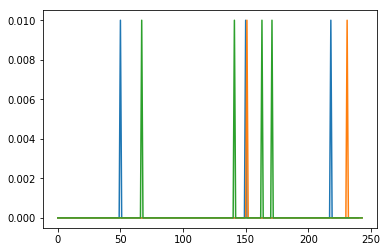

In [27]:
red_3_s[4].plot()
red_3_s[9].plot()
red_3_s[11].plot()
plt.show()

这里，我们用到了画图的功能。
我们知道，这里red_3_s\[i\]是Pandas中提供的Series对象，
它自己直接就提供画图的方法，即plot，可以直接使用。
画出图之后，再用Matplotlib提供的show来显示图片。
我们可以再画几个图来体验一下，先生产一个Series，注意需要用列表来生成：

In [35]:
test = pd.Series([1,2,3,4,5])
print(test)

0    1
1    2
2    3
3    4
4    5
dtype: int64


分成上下两块，然后分别画两种柱状图：

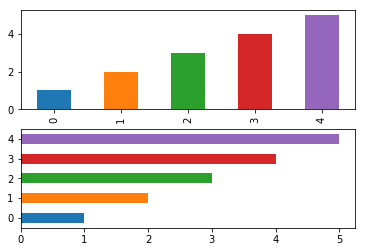

In [50]:
fig, axes = plt.subplots(2, 1)
test.plot(kind='bar', ax=axes[0])
test.plot(kind='barh', ax=axes[1])
plt.show()

画线图，并加上网格：

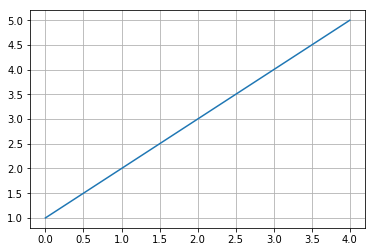

In [37]:
test.plot(grid = True)
plt.show()

画虚线图，并增加图例和标题：

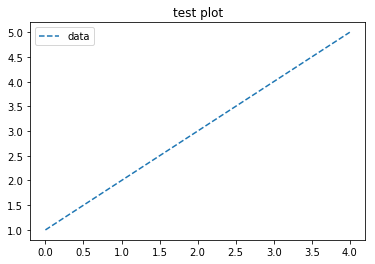

In [41]:
test.plot(style='--',title='test plot',label='data')
plt.legend()
plt.show()

画直方图：

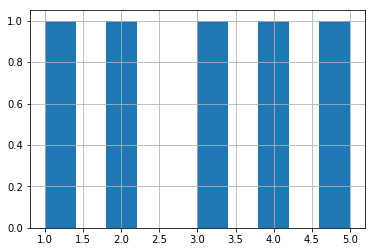

In [54]:
test.hist()
plt.show()

以上，我们得出了收益率的预测值，并大致了解了Series的作图方法。

### 2.2.5 步骤五：检验收益率预测的准确性

既已得到对未来收益的预测，
那么，很自然的，下一步就是测试一下这个预测准不准了。
关于如何判断一个预测模型好不好，
会引入很多假设和复杂的推导，我们放在下一节来讨论。
在本节中，我们采用一个简单的方法，
对预测模型的好坏，做个初步的判断。

我们将计算我们的每日对未来的预测收益率（1%或0%）与未来20天的真实收益率的相关系数。
当然，相关系数的定义多样，最通行的算法是：
$$\mathbf{Corr}(X,Y) = \frac{\mathbf{E}(X - EX)(Y - EY)}{\sigma_X \sigma_Y}$$
然而我们通常会采用一个简化算法：
$$\mathbf{Corr'}(X,Y) = \frac{\mathbf{E}XY}{\sqrt{\mathbf{E}X^2 \cdot \mathbf{E}Y^2}}$$
这个算法基于一些对行情的假设：
1. 在利用短期数据计算收益率的期望时，直接使用考察期内收益率的均值是不恰当的，应使用长期的收益率的均值。既然没有足够的数据，同时又只对短期进行计算，那么，一个既方便又合理的次优解就是假设该期望是0。
2. 同理，在利用短期数据计算预测收益率的期望时，直接记为0也是一个既方便有合理的次优解。
3. 就我们当前的情况而言，我们虽然只预测了“红三兵”，导致预测收益率总是非负的。但“绿三兵”是真实存在的，只是没有计算而已。故预测其实还是对称的，所以其均值取0是不无道理的。

由于大部分时候预测收益率是0%，这为我们大幅降低了运算量。
我们现在有了预测的序列，我们只需要再找出对应的收益率，就可以完成计算了。

这里特别要注意的一点是，我们要使用整个面板数据来计算。
这是因为我们应当假定所有股票是同质的，这样就能放在一起算相关系数了。
如果股票不同质，则应该把不同质的因子找出来，然后控制变量后再计算。
但既然我们目前只考虑“红三兵”这个单一因子，那么我们就应当认同其同质性。

接下来，我们用和前文一样的方法，获得所有待研究股票的未来20日收益率：

In [57]:
rtn = list()
for stock in stock_list:
    data = daily_data[stock]
    r = pd.Series(0.0, index=range(len(data)))
    for i in range(20, len(data)):
        if data.close[i] > 0: r[i] = data.close[i - 20] / data.close[i] - 1
    rtn.append(r)

这样，我们就得到了预测收益率和未来20日真实收益率。

但我们会明显的注意到，上述算法有很多问题，比如我们假定各股票等权重交易，不计手续费，且把持有20天的收益看作在当天就实现。

如何解决这些问题呢？我们把它作为一个课堂练习，同学们就在此处，优化上面这段程序：

In [ ]:
#在这里优化上面一段程序：

下面，我们一方面计算其相关系数； 另一方面，我们还可以假设每次“红三兵”出现，我们就买入，20日之后卖出。 我们可以计算这个策略的收益和资金曲线。

我们先计算并输出相关系数：

In [58]:
sum_xy = 0
sum_x2 = 0
sum_y2 = 0
daily_rtn = pd.Series(0.0, index=range(244))
for i in range(len(stock_list)):
    for j in range(len(red_3_s[i])):
        sum_xy += red_3_s[i][j] * rtn[i][j]
        sum_x2 += red_3_s[i][j] * red_3_s[i][j]
        sum_y2 += rtn[i][j] * rtn[i][j]
        if red_3_s[i][j] > 0 :daily_rtn[j] += rtn[i][j] / 50.0
        
corr = sum_xy / pow(sum_x2 * sum_y2, 0.5)
print(corr)

0.029917573724243494


上面我们计算了相关系数，但我们使用的方法远不完美，
比如，我们并不是使用的无偏估计。

而且，像Python这么优美的语言，是一定有直接计算相关系数的函数的。
请读者自己查找Python中计算相关系数的函数，计算出对应的相关系数：


In [ ]:
#相关系数的计算：

然后我们计算出总收益率，并画出资金曲线图：

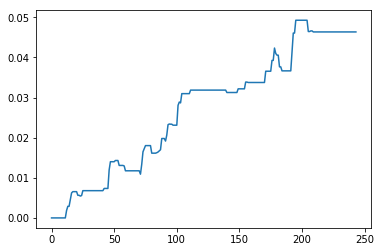

收益率为：4.635919662245827%


In [60]:
cum_rtn = pd.Series(0.0, index=range(len(daily_rtn)))
cum_rtn[0] = daily_rtn[len(daily_rtn) - 1]
for i in range(1, len(cum_rtn)):
    cum_rtn[i] = cum_rtn[i - 1] + daily_rtn[len(daily_rtn) - 1 - i]
cum_rtn.plot()
plt.show()
print("收益率为：",daily_rtn.sum()*100,'%',sep='')

上面，我们画的图都比较简单，读者可应用我们上面讲得画图技巧，画出更漂亮的图。 我们把它作为一个课堂练习，读者可以尝试搜索一下python的画图函数， 了解其详细用法，画一个更漂亮的图在下面：

In [ ]:
#更漂亮的图画在这里：

这样，我们就成功的动手实验得到了一个收益率预测模型，并做了简单的测试。 得到了“红三兵”预测模型的预测收益率和未来20天真实收益率的相关系数约为0.3； 以及其作为一个交易策略的收益率2.3%。

想必大家通过本实验，已经初步了解了python在量化交易中的用法。


## 2.3 延申阅读：培养好的编程习惯

在初步了解Python的用法之后，我们来讲一件非常严肃的事情——关于编程习惯的培养。

好的编程习惯，对我们初学者来说，非常重要。
一般来说，我们应以google等大厂的标准来要求自己。
毕竟，我们在执行的时候，往往会打折扣。
所以标准一定要定得高。

我们在网上搜索“Python 编程规范 google”，
可以得到很多结果，结合Python众社区的通用规范，我们加以整理，展示于此。

### 2.3.1 Python语言方面的准则

#### 2.3.1.1 pychecker

结论：建议使用。

pychecher是从Python源代码中找Bug的工具。由于Python是一种动态化的语言，其中的一些警告可能并不正确，但误报是很罕见的。
它可以比较好的捕捉容易犯的错误，比如拼写错误、在赋值之前就使用变量等等。

#### 2.3.1.2 导入模块和包

结论：
1. 可以使用import x；
2. 谨慎使用from x import y，当且仅当x是一个包，y是一个模块时才可使用。

这可以实现代码的重用，是大型项目必须的。
但它常常会引起一些问题，尤其是依赖上的问题，从而大大增加维护成本。
比如，from foo import \*，就很容易带来依赖上的问题。
为了降低依赖上的问题，减小维护成本，我们才有了上面结论。

#### 2.3.1.3 完整路径导入

结论：
1. 每个模块都应该使用完整路径来导入和引用。
2. 不要为了方便而改变sys.path和PATHONPATH。

这可以避免工作目录变化带来的导入和引用失败。
总之，在导入和引用时，应尽量避免命名上的混乱。

#### 2.3.1.4 异常处理

结论：
1. 模块和包应该定义自己的特定领域的基础异常类，而且这个类应该继承自内置的 Exception 类。这种用于一个模块的基础异常应该命名为 Error。 
2. 不要直接捕获所有异常。
3. 在try/except块内的代码量应尽可能小。

异常处理是好的，但也应按照规范使用。

#### 2.3.1.5 全局变量

结论：避免使用

包括在模块级别声明的变量。除非像PI一类的常量，否则尽量不要使用。

#### 2.3.1.6 内嵌/本地/内部类和函数

结论：可以用

它可以让我们定义只用于一个非常有限的作用域内部的工具类和工具函数，带来了很多方便。

#### 2.3.1.7 List Comprehensions

结论：可以用，但应简明易懂。

带来了效率上的提升，但有时也会使阅读代码变得更困难。Python始终看重简明易懂，即使牺牲一些效率也在所不惜。

#### 2.3.1.8 默认迭代器和运算符

结论：可以用

它们往往简单而高效。注意不要再迭代过程中修改容器中的内容。

#### 2.3.1.9 生成器

结论：可以用，推荐。

它可以使代码更简单，而且几乎没有缺点。

#### 2.3.1.10 使用apply/filter/map/reduce

结论：可以用，但应简明易懂

它们可以使代码更紧凑，是一种内置列表操作函数，通常和lambda函数一起用。但有时也会带来阅读上的困难。

#### 2.3.1.11 lambda函数

结论：可以用，但应简明易懂

它可以使代码更紧凑，但如果强行使用也会使代码更难读懂。

#### 2.3.1.12 默认参数值

结论：可以用，但应遵循规范：
1. 不要把可变对象当作函数或方法定义的默认值
2. 调用函数时应对默认参数进行指名赋值

默认参数确实容易带来一些混乱，但也带来了很多方便。所以，需要在使用时遵循一些规范，减少混乱。

#### 2.3.1.13 Properties

结论：可以用。

它提高了程序的可读性。

#### 2.3.1.14 True/False

结论：可以用。

这是内置的布尔类型的常量，可以用。另外，None、0、{}、()等值也隐含False，可以用于布尔求值，这是代码更简洁，可读性提高。

#### 2.3.1.15 String方法

结论：推荐用。

它包含了过去的string模块的很多方法。string模块已经废弃了，而String的使用几乎没什么缺点，推荐使用。

#### 2.3. 1.16 静态域

结论：可以用。

它往往带来代码的简洁，并无什么缺点。

#### 2.3.1.17 函数和方法修饰符

结论：适度使用

如 @classmethod 和 @staticmethod，它们把普通方法变成类方法或静态方法，它提高了代码的通用性，减少了冗余代码。但它也明显增加了意料之外的隐含行为，给代码增加了不必要的风险。

#### 2.3.1.18 线程

结论：不要用

Google App Engine 不支持线程，所以在其他项目中也不要用。

#### 2.3.1.19 高级特性

结论：不要用

Python有很多很酷炫的特性，能使代码更紧凑。但是紧凑的同时，往往就会牺牲可读性。很多Python程序员是从其它语言转到Python的，对Python的高级特性不够熟悉，为增加一点点紧凑性而大幅牺牲可读性，是不值得的。这也对推广Python不利。

### 2.3.2 Python编码风格方面的准则

#### 2.3.2.1 分号

结论：避免使用

不用把两个语句放在一行，也不要把分号作为行的结束符。

#### 2.3.2.2 每行长度

结论：最多80个字符

只有导入模块的行可以超过80个字符。如需分行，避免使用'\'，应使用括号，确保分行的位置在括号内。

#### 2.3.2.3 圆括号

结论：吝啬使用

尤其在以下情况，尽量不用：
1. return语句中
2. 条件语句中，除非2.5.2.2中所述情形
3. 在元组周围

以下情形可以用：
1. 长表达式中，用于提高可读性
2. 上述2.5.2.2中情形
3. 运算符优先级比较复杂的情形，用于提高可读性

#### 2.3.2.4 缩进

结论：使用4个空格，不要用tab

这个问题尚有争议，我们推荐这种用法。

#### 2.3.2.5 空行

结论：对函数和类用2空行，对类的方法用1空行

#### 2.3.2.6 空格

结论：
1. 括号内侧不要加空格
2. 在逗号、分号、冒号前面不要加空格。
3. 逗号、分号、冒号后面必须加空格，除非那是行尾。
4. 在表示参数、列表、下标、分块开始的圆括号/方括号前面不要加空格。
5. 在二元运算符两边各家一个空格。
6. 等号用于指名参数或默认参数值时，两边不要加空格。

#### 2.3.2.7 Python解释器

结论：用Google App Engine当前使用的那个。

#### 2.3.2.8 注释

结论：推荐使用__doc__String

这是Python特有的。

#### 2.3.2.9 类

结论：如果不从其他基类继承，那就应该明确地从object基类继承。

这一条对嵌套类也适用。

#### 2.3.2.10 字符串

结论：
1. 字符串拼接时，避免使用+/+=，应使用%格式化字符串。除非是非常简单的情形。
2. 多行字符串尽量不要用三引号，应使用括号。

#### 2.3.2.11 TODO style

结论：应使用：#TODO(username)

主要是为了统一格式，方便按用户名检索。

#### 2.3.2.12 import分组及顺序

结论：
1. 一行一个
2. import 应该按照从最常用到最不常用的顺序分组放置：
    1. import 标准库
    2. import 第三方库
    3. import Google App Engine 相关库
    4. import Django 框架相关库
    5. import SoC framework 相关库
    6. import 基于 SoC 框架的模块
    7. import 应用程序特有的内容
3. 组内按字母顺序放置。

#### 2.3.2.13 语句

结论：一行只放一个语句，避免使用分号。

#### 2.3.2.14 访问控制

结论：
1. 简单程序直接公开变量
2. 复杂程序应使用getFoo()/setFoo()来访问foo

#### 2.3.2.15 命名

结论：
1. 类名使用驼峰命名，首字母大写
2. 常量全大写
3. 其他变量和函数采用小写+下划线命名

这个问题上Google和PEP8的建议不同，我们采用PEP8的建议。

#### 2.3.2.16 程序入口

结论：所有代码都应可以被导入，所以请注意导入时可能出现的问题。